In [1]:
# import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.utils as vutils
# from pytorch_lightning import Trainer
import lightning as pl
# import pl.Trainer

from torch.optim import Adam
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder, Flowers102, MNIST

import matplotlib.pyplot as plt

torch.manual_seed(42)

In [2]:
class Autoencoder(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.val_outputs = []

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 2, 2, 1, bias=False),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(True),
            nn.Conv2d(8, 24, 3, 2, 1, bias=False),
            nn.BatchNorm2d(24),
            nn.LeakyReLU(True),
            nn.Conv2d(24, 64, 3, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(True),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 24, 3, 2, 1, bias=False),
            nn.BatchNorm2d(24),
            nn.ReLU(True),
            nn.ConvTranspose2d(24, 8, 3, 2, 1, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        
        return x

    def prepare_data(self):
        transform = transforms.Compose(
            [
                transforms.Resize((64, 64)),
                transforms.ToTensor(),
            ]
        )

        dataset = MNIST(root='/home/maxim/Documents/TestProject/mnist/', download=True, transform=transform)

        end_train_idx = int(len(dataset) - len(dataset) / 5)
        end_val_idx = int(len(dataset) - len(dataset) / 7)
        end_test_idx = len(dataset)

        self.train_dataset = Subset(dataset, range(0, end_train_idx))
        self.val_dataset = Subset(dataset, range(end_train_idx + 1, end_val_idx))
        self.test_dataset = Subset(dataset, range(end_val_idx + 1, end_test_idx))

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset, batch_size=32, shuffle=True, num_workers=20
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset, batch_size=32, num_workers=20
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset, batch_size=32, num_workers=20
        )

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=0.0001)

    def training_step(self, batch, batch_idx):
        x, _ = batch
        output = self(x)
        
        loss = F.mse_loss(output, x)

        logs = {"loss": loss}
        return {"loss": loss, "log": logs}

    def validation_step(self, batch, batch_idx):
        x, _ = batch
        output = self(x)
        loss = F.mse_loss(output, x)
        logs = {"val_loss": loss}

        self.log("val_loss", loss)

        self.val_outputs.append(output[0])

        return {"val_loss": loss, "log": logs}

    def test_step(self, batch, batch_idx):
        x, _ = batch
        output = self(x)
        loss = F.mse_loss(output, x)

        plt.imshow(output.cpu().numpy()[0, 0, :, :])

        return {"test_loss": loss}
    
    def on_validation_epoch_end(self):
        grid = vutils.make_grid(self.val_outputs)
        self.logger.add_image("generated_images", grid, self.current_epoch)
        self.logger.close()

        self.val_outputs.clear()

val_loss: tensor(0.0008, device='cuda:0')
Loss 0: tensor(0.0008, device='cuda:0')
val_loss: tensor(0.0008, device='cuda:0')
Loss 1: tensor(0.0008, device='cuda:0')
val_loss: tensor(0.0007, device='cuda:0')
Loss 2: tensor(0.0007, device='cuda:0')
val_loss: tensor(0.0007, device='cuda:0')
Loss 3: tensor(0.0007, device='cuda:0')
val_loss: tensor(0.0007, device='cuda:0')
Loss 4: tensor(0.0007, device='cuda:0')
val_loss: tensor(0.0007, device='cuda:0')
Loss 5: tensor(0.0007, device='cuda:0')
val_loss: tensor(0.0007, device='cuda:0')
Loss 6: tensor(0.0007, device='cuda:0')
val_loss: tensor(0.0007, device='cuda:0')
Loss 7: tensor(0.0007, device='cuda:0')
val_loss: tensor(0.0008, device='cuda:0')
Loss 8: tensor(0.0008, device='cuda:0')
val_loss: tensor(0.0007, device='cuda:0')
Loss 9: tensor(0.0007, device='cuda:0')
val_loss: tensor(0.0007, device='cuda:0')
Loss 10: tensor(0.0007, device='cuda:0')
val_loss: tensor(0.0008, device='cuda:0')
Loss 11: tensor(0.0008, device='cuda:0')
val_loss: tens

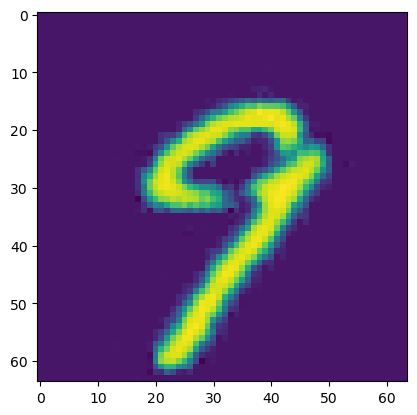

In [3]:
from pytorch_lightning.callbacks import EarlyStopping
from torchsummary import summary

model = Autoencoder()

trainer = pl.Trainer(epochs=5, accelerator='cuda', checkpoint_loc='/home/maxim/Documents/TestProject/maxim-lightning/checkpoint.pt', checkpoint_freq=0)#, callbacks=[EarlyStopping(monitor="val_loss", mode="min")])
trainer.fit(model)
trainer.validate(model)
trainer.test(model)

In [4]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/